In [1]:
import logging
import warnings

import numpy as np

np.set_printoptions(precision=4)
warnings.filterwarnings("ignore")


logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Model system: 1D ideal gas in a linear external potential

Below we gain intuition for the analytical model included in the thermoextrap package. Specifically, we have a system with $N$ ideal gas (IG) particles with a single dimension of length $L$. The potential energy for each particle is only a function of the particle location, $U(x) = ax$ where $x$ is the position of a particle along the single dimension. In what follows, $\beta=\frac{1}{k_{B}T}$ is the inverse temperature and we set the energy associated with particular position due to the external potential, $a$, equal to 1. This does not lose any generality as only values of $\beta$ or $L$ relative to $a$ matter.

Though this system is simple and completely analytical, it can be used to test nearly all of the functionalities of the {mod}`thermoextrap` package. As a result, it is featured in the unit testing to ensure that the code is not only reproducible, but also produces physically correct results coinciding with theory.  This code is located in the module {mod}`thermoextrap.idealgas`.

In [2]:
%matplotlib inline

import cmomy
import matplotlib.pyplot as plt
import numpy as np

from thermoextrap import idealgas

rng = cmomy.random.default_rng(seed=0)

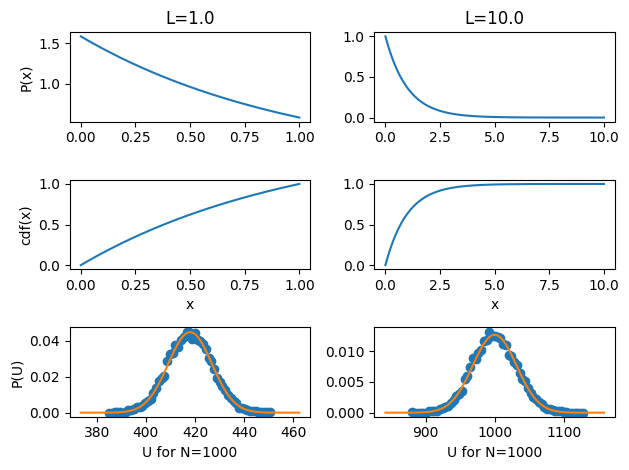

In [3]:
beta = 1.0
npart = 1000
nconfig = 10000

fig, axes = plt.subplots(3, 2)


def get_utest(npart, beta, vol, ndev=5, n=100):
    uave = idealgas.x_ave(beta, vol) * npart
    ustd = np.sqrt(idealgas.x_var(beta, vol) * npart)
    return np.linspace(-1.0, 1.0, n) * ndev * ustd + uave


# Note for ideal gas model, vol = length
vols = [1.0, 10.0]

for vol, ax in zip(vols, axes.T):
    xvals = np.arange(0.0, vol, 0.0001)

    # There are functions to sample both position and potential energy values
    uvals = idealgas.u_sample((nconfig, npart), beta, vol)
    uhist, ubins = np.histogram(uvals, bins="auto", density=True)
    ubincents = 0.5 * (ubins[:-1] + ubins[1:])

    # We can also just directly calculate the average or variance of the particle positions
    utest = get_utest(npart, beta, vol)

    # Or you can get the probability distribution of x or U
    ax[0].set_title(f"L={vol}")
    ax[0].plot(xvals, idealgas.x_prob(xvals, beta, vol))
    ax[1].plot(xvals, idealgas.x_cdf(xvals, beta, vol))
    ax[2].plot(ubincents, uhist, "o")
    ax[2].plot(utest, idealgas.u_prob(utest, npart, beta, vol))

for a in axes[1, :]:
    a.set_xlabel("x")
for a in axes[2, :]:
    a.set_xlabel(f"U for N={npart}")
for a, label in zip(axes[:, 0], ["P(x)", "cdf(x)", "P(U)"]):
    a.set_ylabel(label)

fig.tight_layout()

The probability of a particle residing at a particular location is $\frac{e^{-\beta a x}}{\int_0^L e^{-\beta a x} dx}$, shown in the top panel. The cumulative distribution function, which is used to randomly sample from the distribution $P(x)$, is shown in the middle. From $N$ random draws of $x$ distributed according to $P(x)$, you have a single configuration with $N$ particles. The potential energy for a single configuration is $a \sum_i x_i$ and so by randomly sampling many configurations, we construct the potential energy distribution in the bottom panel. For a single particle, the potential energy distribution is identical to $P(x)$ since a single $x$ maps to exactly one potential energy. For many particles, however, the potential energy is a random variable composed of a sum of independent random variables and so the distribution is Gaussian, as confirmed by the bottom panel.

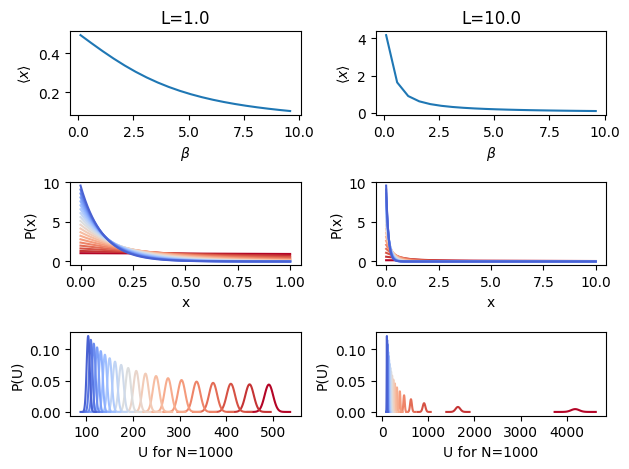

In [4]:
# Now look at behavior as a function of inverse temperature (at the same system sizes as above)

betas = np.arange(0.1, 10.0, 0.5)
colors = plt.cm.coolwarm_r(np.arange(0.0, 1.0, float(1.0 / len(betas))))

fig, axes = plt.subplots(3, 2)

for vol, ax in zip(vols, axes.T):
    xvals = np.arange(0.0, vol, 0.0001)
    ax[0].set_title(f"L={vol}")
    ax[0].plot(betas, idealgas.x_ave(betas, vol))

    for beta, color in zip(betas, colors):
        ax[1].plot(xvals, idealgas.x_prob(xvals, beta, vol), color=color)
        utest = get_utest(npart, beta, vol)
        ax[2].plot(utest, idealgas.u_prob(utest, npart, beta, vol), color=color)

    ax[0].set_xlabel(r"$\beta$")
    ax[0].set_ylabel(r"$\langle x \rangle$")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("P(x)")
    ax[2].set_xlabel(f"U for N={npart}")
    ax[2].set_ylabel("P(U)")


fig.tight_layout()

plt.show()

A simple structural property of interest is the average $x$ value, which is plotted in the top panel as a function of $\beta$. It's only non-linear over a very large temperature range, but it's a toy system so the physical temperature really isn't relevant anyway. Changes in $P(x)$ and $P(U)$ with temperature are shown as well with coloring by temperature, NOT inverse temperature (blue is the lowest $T$, highest $\beta$). Clearly the configurational distributions will not overlap in their important regions and neither will the potential energy distributions, meaning perturbation won't work at some point. This is especially true as $L$ is increased.

Below, we show $\langle x \rangle$ as a function of $L$ at various temperatures. Non-linearities arise at all temperatures to varying degrees.

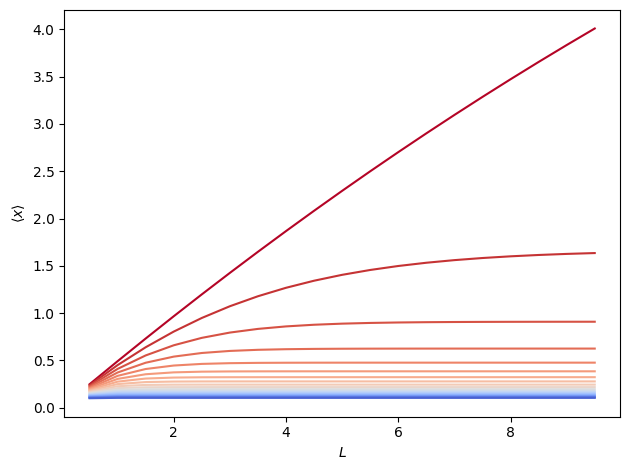

In [5]:
# Behavior of average x as a function of L
fig, ax = plt.subplots()
vols = np.arange(0.5, 10.0, 0.5)

for beta, color in zip(betas, colors):
    ax.plot(
        vols,
        idealgas.x_ave(beta, vols),
        color=color,
        label=rf"$\beta$ = {beta}",
    )

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$\langle x \rangle$")

fig.tight_layout()

plt.show()

For testing for physical accuracy, note that the {mod}`thermoextrap.idealgas` module also comes with analytical computations of the derivatives with respect to $\beta$ of $\langle x \rangle$, $\langle \beta x \rangle$, $-\ln \langle x \rangle$, and $-\ln \langle \beta x \rangle$. This allows for "exact" extrapolations at a given order, or at least what the extrapolation at that order should be in the limit of infinite sampling. There is also a function to compute analytical derivatives, and hence extrapolations, with respect to $L$. As we will explore in other notebooks, these scenarios cover most cases of interest in extrapolating structural and thermodynamic properties. For more information, see [here](https://doi.org/10.1063/5.0014282).